In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np

import scipy.optimize as sco

import warnings
warnings.filterwarnings('ignore')

import sklearn.cluster as cl
from sklearn import mixture

data_folder = '../data/'
path = data_folder + 'GEV_SM/swissmetro.dat'

from classes.MNLogit import *
from helpers.data import *
from helpers.algos import *
from helpers.models import *
import copy

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import time
import pickle

import hyperopt
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import seaborn as sns

import numdifftools as nd

sns.set(font_scale=1.5)

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

seed = 1234

In [3]:
model = load_model(path, 'norm')
x = np.zeros(len(model.params))

In [4]:
%%time
res_bfgs = sco.minimize(model.negloglikelihood, x, method='BFGS', tol=1e-8, jac=model.neg_grad)

CPU times: user 2.6 s, sys: 12 ms, total: 2.61 s
Wall time: 2.62 s


In [5]:
res_bfgs.x

array([ 0.786179  ,  0.98264685, -0.65596648, -1.04933718, -0.68768718,
       -1.05748236, -0.8000895 , -1.44306552, -1.45576372, -1.79689044])

In [6]:
res_bfgs.fun

0.7908058095403135

# SGD

In [7]:
nbr = 20
draws = 10

res = {}

In [19]:
dct = {}  

start = time.time()
epochs, xs, lls = line_search_mbSGD(model, x, nbr, len(model.df), False)
stop = time.time()

dct['epochs'] = epochs
dct['lls'] = lls
dct['times'] = stop-start

res['GD'] = dct

Start Line search mini batch SGD for 20 epochs (20 iterations)


In [12]:
np.random.seed(seed)

dct = {}

lls = []
times = []
for d in range(draws):
    
    start = time.time()
    ep, x_val, ll = line_search_mbSGD(model, x, nbr, 100, False)
    stop = time.time()
    
    times.append(stop-start)
    lls.append(ll)
    
dct['epochs'] = np.array(ep)
dct['lls'] = np.array(lls)
dct['times'] = np.array(times)

res['SGD-100'] = dct    

Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)
Start Line search mini batch SGD for 20 epochs (1808 iterations)


In [13]:
np.random.seed(seed)

dct = {}

lls = []
times = []
for d in range(draws):
    
    start = time.time()
    ep, x_val, ll = line_search_mbSGD(model, x, nbr, 1000, False)
    stop = time.time()
    
    times.append(stop-start)
    lls.append(ll)
    
dct['epochs'] = np.array(ep)
dct['lls'] = np.array(lls)
dct['times'] = np.array(times)

res['SGD-1000'] = dct  

Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)
Start Line search mini batch SGD for 20 epochs (181 iterations)


In [20]:
with open('../data/SGD2.p', 'wb') as outfile:
    pickle.dump(res, outfile)

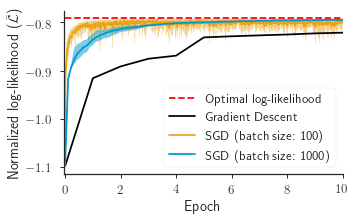

In [11]:
with open('../data/SGD2.p', 'rb') as infile:
    res = pickle.load(infile)
    
colors = {'SGD-100': (232/255,164/255,29/255), 
          'SGD-1000': (0/255,152/255,205/255)}

labels = {
    'GD': 'Gradient Descent',
    'SGD-100': 'SGD (batch size: 100)',
    'SGD-1000': 'SGD (batch size: 1000)'
}

plt.figure(figsize=(5,3), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.3)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot([res['GD']['epochs'][0], res['GD']['epochs'][-1]], 
        [-res_bfgs.fun, -res_bfgs.fun], 'r--', 
        label='Optimal log-likelihood')

ax.plot(res['GD']['epochs'], res['GD']['lls'], 'k', label=labels['GD'])

for key in ['SGD-100', 'SGD-1000']:
    
    epochs = res[key]['epochs']
    
    plus = []
    minus = []
    avg = []
    
    vals = res[key]['lls']
    
    for i in range(vals.shape[1]):
        avg.append(np.mean(vals[:,i]))
        minus.append(np.percentile(vals[:,i], 5))
        plus.append(np.percentile(vals[:,i], 95))
    
    ax.plot(epochs, avg, linestyle='-', color=colors[key], label=labels[key])
    ax.fill_between(epochs, plus, minus, color=colors[key], alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('Normalized log-likelihood ($\\bar{\\mathcal{L}}$)')
leg = ax.legend(frameon=True)

max_ep = 10

ax.set_xlim([-0.05, max_ep])
plt.savefig('../figures/SGD{}.pdf'.format(max_ep), bbox_inches='tight')

In [13]:
for algo in res.keys():
    
    avg = {}
    
    idx = next(x[0] for x in enumerate(res[algo]['epochs']) if x[1] >= 10)

    lls = res[algo]['lls']
    
    try:
        tmp = lls[:,idx]

        avg = np.mean(tmp)
    except:
        avg = lls[idx]
        
    print("  LL for {}: {:.6f}".format(algo, avg))

  LL for GD: -0.821341
  LL for SGD-100: -0.797970
  LL for SGD-1000: -0.794238
